## 📦 **Import Libraries**

In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.8 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Mounted at /content/drive


## 🗃️ **Data Preparation**

In [3]:
dir = '/content/drive/MyDrive/Colab Notebooks/ml-stuff/data/'

projects = pd.read_csv(dir + 'projects_stemming_and_then_remove_stopwords.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [4]:
projects.head()

,Unnamed: 0.1,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,0,tulis tinggal apartemen jakarta tulis 1 artike...,7.0,['Writing'],250000.0
1,1,1,buat artikel media online kerja buat artikel s...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,2,editing 12 shortt video konten tiktok hi ada 1...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,3,cari akun canva creator element template punya...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,4,cari jasa upload aplikasi app store sedang car...,7.0,['iPhone/iOS'],150000.0


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

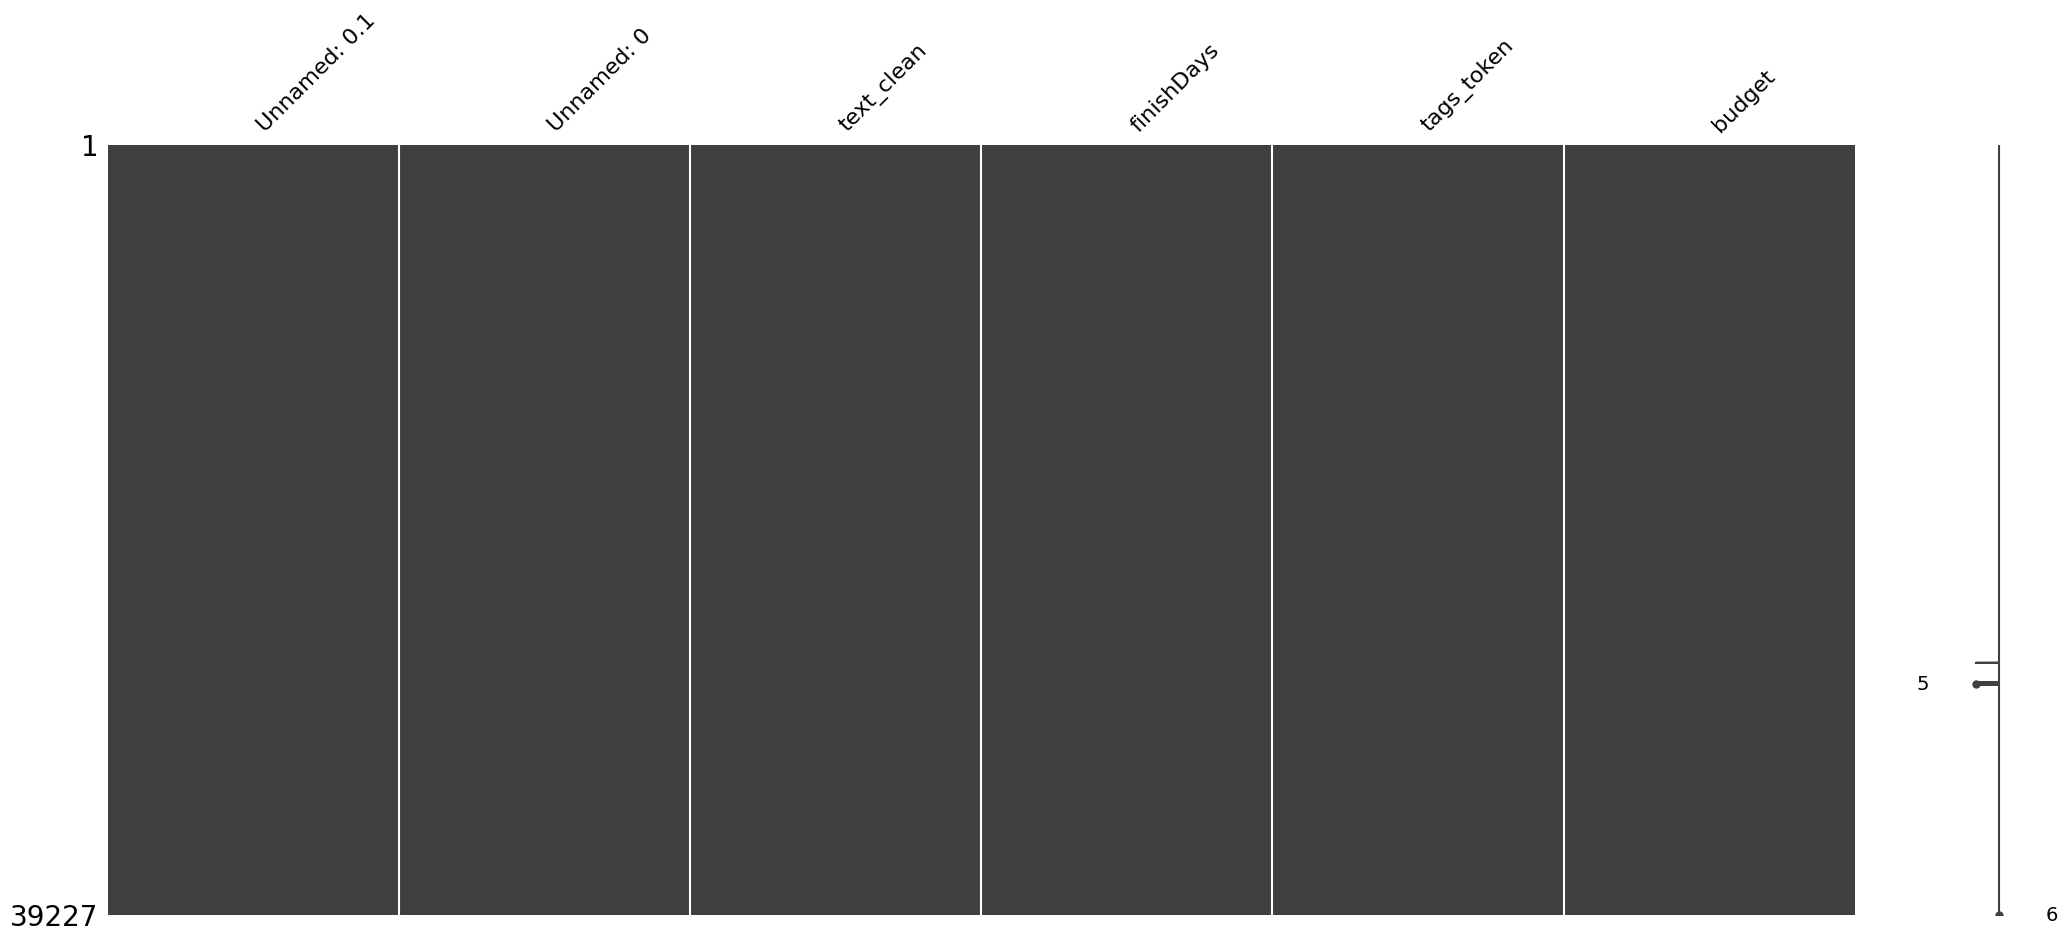

In [5]:
msno.matrix(projects)
plt.show()

In [6]:
round(projects.isna().mean().sort_values(ascending = False), 4)

text_clean      0.0001
Unnamed: 0.1    0.0000
Unnamed: 0      0.0000
finishDays      0.0000
tags_token      0.0000
budget          0.0000
dtype: float64

In [7]:
df = projects

In [8]:
df

,Unnamed: 0.1,Unnamed: 0,text_clean,finishDays,tags_token,budget
0,0,0,tulis tinggal apartemen jakarta tulis 1 artike...,7.0,['Writing'],250000.0
1,1,1,buat artikel media online kerja buat artikel s...,7.0,"['Blog', 'Blogspot', 'Content Management Syste...",350000.0
2,2,2,editing 12 shortt video konten tiktok hi ada 1...,7.0,"['Social Media Marketing (SMM)', 'Adobe Illust...",200000.0
3,3,3,cari akun canva creator element template punya...,7.0,"['Design Arts', 'Graphic Design', 'Logo Design...",1000000.0
4,4,4,cari jasa upload aplikasi app store sedang car...,7.0,['iPhone/iOS'],150000.0
...,...,...,...,...,...,...
39222,39222,39222,terjemah bahasa inggris bahasa indonesia terje...,7.0,['English'],600000.0
39223,39223,39223,buat lagu buat lagu genre anak anak durasi lag...,7.0,['Cakewalk'],800000.0
39224,39224,39224,buat banner promosi produk ukur 336x280 160x60...,5.0,['Graphic Design'],600000.0
39225,39225,39225,edit foto edit foto dan ingin hasil foto hias ...,3.0,['Adobe PhotoShop'],250000.0


In [9]:
df.rename(columns = {'tags_token':'project_tags'}, inplace = True)

##`project_tags`

In [10]:
# Filtering the rare terms.
df_filtered = df.groupby("project_tags").filter(lambda x: len(x) > 1)
df_filtered['project_tags']

0                                              ['Writing']
3        ['Design Arts', 'Graphic Design', 'Logo Design...
4                                           ['iPhone/iOS']
5                                              ['Writing']
6                 ['Data Entry', 'Quesioner', 'Responden']
                               ...                        
39221                                  ['Email Marketing']
39222                                          ['English']
39224                                   ['Graphic Design']
39225                                  ['Adobe PhotoShop']
39226                     ['CorelDRAW', 'Adobe PhotoShop']
Name: project_tags, Length: 27838, dtype: object

In [11]:
import ast 

df_filtered['project_tags'] = [ast.literal_eval(i) for i in df_filtered['project_tags']]
df_filtered['project_tags'].values[:5]

array([list(['Writing']),
       list(['Design Arts', 'Graphic Design', 'Logo Design', 'Canva']),
       list(['iPhone/iOS']), list(['Writing']),
       list(['Data Entry', 'Quesioner', 'Responden'])], dtype=object)

In [12]:
df_filtered = df_filtered.drop('Unnamed: 0', axis = 1)

In [13]:
df_filtered['text'] = df_filtered['text_clean']
df_filtered['text'] = df_filtered['text'].astype(str)

## Base Model

In [14]:
df_filtered

,Unnamed: 0.1,text_clean,finishDays,project_tags,budget,text
0,0,tulis tinggal apartemen jakarta tulis 1 artike...,7.0,[Writing],250000.0,tulis tinggal apartemen jakarta tulis 1 artike...
3,3,cari akun canva creator element template punya...,7.0,"[Design Arts, Graphic Design, Logo Design, Canva]",1000000.0,cari akun canva creator element template punya...
4,4,cari jasa upload aplikasi app store sedang car...,7.0,[iPhone/iOS],150000.0,cari jasa upload aplikasi app store sedang car...
5,5,butuh tulis artikel zodiac sila sebut bids sud...,10.0,[Writing],200000.0,butuh tulis artikel zodiac sila sebut bids sud...
6,6,sebar kuesioner sleman butuh jasa sebar respon...,3.0,"[Data Entry, Quesioner, Responden]",150000.0,sebar kuesioner sleman butuh jasa sebar respon...
...,...,...,...,...,...,...
39221,39221,data email kumpul data data email usaha seluru...,12.0,[Email Marketing],1000000.0,data email kumpul data data email usaha seluru...
39222,39222,terjemah bahasa inggris bahasa indonesia terje...,7.0,[English],600000.0,terjemah bahasa inggris bahasa indonesia terje...
39224,39224,buat banner promosi produk ukur 336x280 160x60...,5.0,[Graphic Design],600000.0,buat banner promosi produk ukur 336x280 160x60...
39225,39225,edit foto edit foto dan ingin hasil foto hias ...,3.0,[Adobe PhotoShop],250000.0,edit foto edit foto dan ingin hasil foto hias ...


In [15]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["project_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 25054
Number of rows in validation set: 1392
Number of rows in test set: 1392


In [16]:
train_df["text"].apply(lambda x: len(x.split(" "))).describe()

count    25054.000000
mean        47.075916
std         23.890951
min          1.000000
25%         28.000000
50%         45.000000
75%         63.000000
max        393.000000
Name: text, dtype: float64

In [17]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [18]:
terms = tf.ragged.constant(train_df["project_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Writing', 'PHP', 'Content Writer', 'Copywriter', 'Wordpress', 'Adobe PhotoShop', 'Data Entry', 'Search Engine Optimization (SEO)', 'Blog', 'Graphic Design', 'MySQL', 'Web Programming', 'Website', 'CodeIgniter', 'CorelDRAW', 'Android', 'Adobe Illustrator', 'Microsoft Word', 'HTML', 'Wordpress Templates', 'Laravel Framework', 'Logo Design', 'Web Design', 'CSS', 'Android studio', 'Internet Marketing', 'JavaScript', 'Website Building', 'Blogspot', 'Mobile Programming', 'Website Templates', 'Social Media Marketing (SMM)', 'English', 'Microsoft Excel', 'Video Editing', 'Video Production', 'Design Arts', 'Translation', 'Bootstrap', 'Market Research', 'Python', 'Web Research', 'Java', 'Web Scrapping', 'Instagram', 'Screenwriting', 'jQuery', 'Administration', 'Adobe Indesign', 'WooCommerce', 'Data Mining', 'Corel PhotoPaint', 'Facebook', 'E-Commerce', 'Data Analysis', 'Adobe Premiere', 'Adobe After Effects', 'Youtube', 'CSS Templates', 'Microsoft Office', 'Database Progr

In [19]:
sample_label = train_df["project_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Android studio']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [20]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["project_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [21]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [22]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Text: b'worker freelancer pasang 1000 post forum batch 17 perhati anda mau komitmen kerja project sesuai syarat bawah jangan bid anda dapat rating buruk anda sulit menang project project lanjut harap baca seluruh deskripsi bawah belum bid adalah project post forum batch 16 butuh orang worker freelancer laku post atau sundul forum terkadang jarang sekali hampir tidak pernah kirim email lewat account gmail sudah sedia'
Label(s): ['Data Entry']
 
Text: b'buat artikel seo butuh content writer 2 blog seo website milik usaha kerja syarat masing masing orang blog 1 satu hari saji 1 artikel artikel authentic kutip sumber foto artikel artikel lengkap foto cantum sumber foto tema artikel tech savvy artikel minimal 400 kata blog 2 satu hari saji 1 artikel artikel harus authentic kutip harus serta sumber harus serta foto artikel artikel lengkap foto harus cantum sumber foto'
Label(s): ['Writing' 'Copywriter' 'Search Engine Optimization (SEO)']
 
Text: b'buat website project kecil kecil buat websit

In [23]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

32423


In [24]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [25]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [26]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
196/196 [==============================] - 10s 17ms/step - loss: 0.0573 - binary_accuracy: 0.9819 - val_loss: 0.0193 - val_binary_accuracy: 0.9946
Epoch 2/20
196/196 [==============================] - 3s 16ms/step - loss: 0.0132 - binary_accuracy: 0.9959 - val_loss: 0.0176 - val_binary_accuracy: 0.9948
Epoch 3/20
196/196 [==============================] - 3s 17ms/step - loss: 0.0068 - binary_accuracy: 0.9978 - val_loss: 0.0194 - val_binary_accuracy: 0.9948
Epoch 4/20
196/196 [==============================] - 4s 22ms/step - loss: 0.0040 - binary_accuracy: 0.9988 - val_loss: 0.0229 - val_binary_accuracy: 0.9948
Epoch 5/20
196/196 [==============================] - 3s 16ms/step - loss: 0.0028 - binary_accuracy: 0.9992 - val_loss: 0.0249 - val_binary_accuracy: 0.9947
Epoch 6/20
196/196 [==============================] - 3s 16ms/step - loss: 0.0022 - binary_accuracy: 0.9994 - val_loss: 0.0268 - val_binary_accuracy: 0.9948
Epoch 7/20
196/196 [==============================] - 3s 

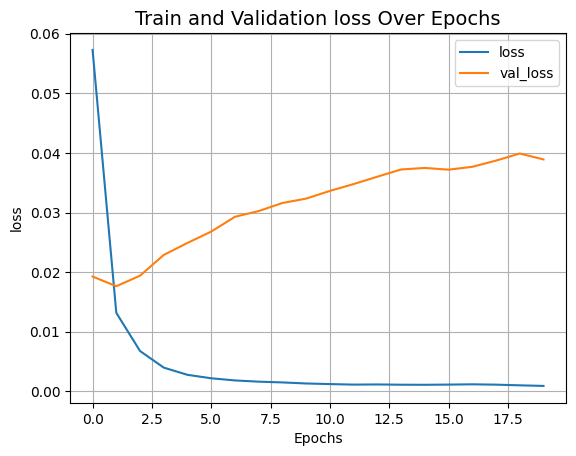

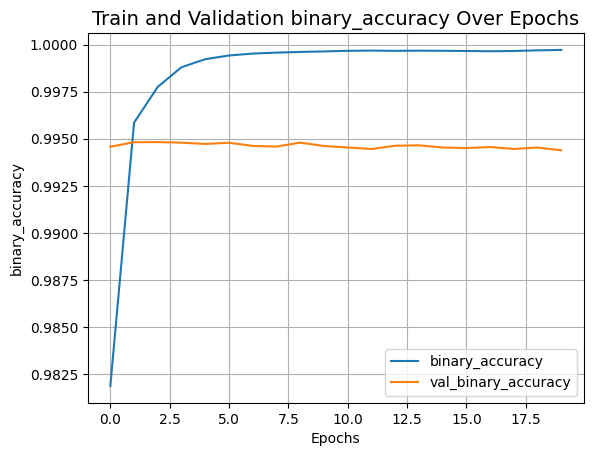

In [27]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [28]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

11/11 [==============================] - 0s 11ms/step - loss: 0.0357 - binary_accuracy: 0.9945
Categorical accuracy on the test set: 99.45%.


In [29]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_5_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_5_labels])})")
    print(" ")

4/4 [==============================] - 0s 6ms/step
Text: b'terjemah bahasa inggris bismillah sahabat freelancer punya mampu bahasa inggris profesional bantu terjemah bahasa inggris informasi lebgkapnya kami ikan saat bidding sila bid ada istilah perlu paham tanya tanya hasil sempurna sesuai konteks maksud asli bahasa indonesia dalam kaidah bahasa inggris'
Label(s): ['English' 'Translation']
Predicted Label(s): (English, Translation, Appraisal, Internet Marketing, Copywriter)
 
Text: b'urgent edit makalah bahasa indonesia 800 kata urgent need proofread makalah bahasa indonesia baru translate pakai google translate bahasa indonesia bahasa inggris 800 kata edit flow kalimat sambung tidak google translated waktu selesai 1 hari butuh cepat kasih'
Label(s): ['Writing' 'Microsoft Word']
Predicted Label(s): (Writing, Microsoft Word, Copywriter, Content Writer, Administration)
 
Text: b'baik ssl website bas wordpress ingin baik website bas wordpress dihost kampus domain ac id kondisi website se